In [ ]:
###########################################################################
#                           Testing Models                                #
########################################################################### 
def Modeltest(X_test, y_test, y_pred, model, model_name, SVM = False):
    f1 = round(f1_score(y_test, y_pred, average="macro"), 3 )
    print('F1 Score: ', f1)
    ps = round(precision_score(y_test, y_pred, average="macro") * 100, 2 )
    print('precision Score: ', ps)
    rs = round(recall_score(y_test, y_pred, average="macro") * 100, 2 )
    print('Recall Score: ', rs)
    acc_nb = round(metrics.accuracy_score(y_test, y_pred) * 100, 2 )
    print('Total Accuracy: ', acc_nb )
    if SVM == True:
        roc = 'NaN'
    else:
        y_pred = model.predict_proba(X_test)[:, 1]
        roc = round(roc_auc_score(y_test,y_pred), 3 )
        print('ROC AUC Score : ',roc)
        
    score_table[model_name] = [f1, ps, rs, acc_nb, roc]
    score_table.index = ['F1 Score','precision Score','Recall Score','Total Accuracy','ROC_AUC Score']
    return np.array([f1, ps, rs, acc_nb, roc])

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report


from sklearn.metrics import confusion_matrix
def draw_cm(actual, predicted):
    cm = confusion_matrix( actual, predicted, [1,0]).T
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Yes","No"] , yticklabels = ["Yes","No"] )
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()
    
def plot_tree(model):
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.ylabel('mLog Loss')
    plt.title('Model mLog Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('Model Classification Error')
    plt.show()


In [ ]:
###########################################################################
#                             All Models                                  #
###########################################################################     
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# Random Forest Classifier
def randf(X_train, y_train, X_test, y_test):

    # Create a Random Forest Classifier
    rf = RandomForestClassifier()

    # Hyperparameter Optimization
    parameters = {'n_estimators': [4, 6, 9, 10, 15, 25, 50], 
                  'max_features': ['log2', 'sqrt','auto'], 
                  'criterion': ['entropy', 'gini'],
                  'max_depth': [2, 3, 4, 5, 7, 10], 
                  'min_samples_split': [2, 3, 5],
                  'min_samples_leaf': [1, 5, 8]
                 }

    # Run the grid search
    grid_obj = GridSearchCV(rf, parameters)
    grid_obj = grid_obj.fit(X_train, y_train)

    # Set the rf to the best combination of parameters
    rf = grid_obj.best_estimator_
    print(grid_obj.best_params_)
    # Train the model using the training sets 
    rf.fit(X_train,y_train)
    
    # Test
    y_pred = rf.predict(X_test)
    
    # Confusion matrix and test 
#     draw_cm(y_test, y_pred)
#     Modeltest(X_test, y_test, y_pred, rf, 'Random Forest', SVM = False)
    
    return rf



from xgboost import XGBClassifier, plot_importance
def boost(X_train, y_train, X_test, y_test):
    # eXtreme Gradient Boosting



    # Create a XGB Classifier
    gbm = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='multi:softmax', silent=True, nthread=1, num_class=5)

    # A parameter grid for XGBoost for Hyperparameter Optimization
    parameters = {
            'min_child_weight': [5, 10],
            'gamma': [0.1, 0.5, 2, 5],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.6, 0.8],
            'max_depth': [10,15]
            }

    # Run the grid search
    grid_obj = GridSearchCV(gbm, parameters)
    grid_obj = grid_obj.fit(X_train, y_train)

    
    # Set the rf to the best combination of parameters
    gbm = grid_obj.best_estimator_

    # Train the model using the training sets
    gbm.fit(X_train, y_train)
    
    # Prediction on test data
    y_pred = gbm.predict(X_test)
    
#     # Confusion matrix and test 
#     draw_cm(y_test, y_pred)
#     Modeltest(X_test, y_test, y_pred, gbm, 'XGBoost GridSearchCV', SVM = False)
    
    return gbm

from sklearn.metrics import precision_score, accuracy_score
import xgboost as xgb

def fast_boost(X_train, y_train, X_test, y_test):
    
        # https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf
    from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
       
#     space = {
#         'max_depth' : hp.choice('max_depth', range(4, 15, 1)),
#         'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
#         'n_estimators' : hp.choice('n_estimators', range(5, 205, 5)),
#         'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
#         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
#         'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
#         'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

    
    space = {
        'max_depth' : hp.choice('max_depth', range(5, 15, 1)),
        'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
        'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
        'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

    from sklearn.model_selection import train_test_split

    def objective(space):
        
        classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                                max_depth = int(space['max_depth']),
                                learning_rate = space['learning_rate'],
                                gamma = space['gamma'],
                                min_child_weight = space['min_child_weight'],
                                subsample = space['subsample'],
                                colsample_bytree = space['colsample_bytree']
                                )

        classifier.fit(X_train, y_train)

        # Applying k-Fold Cross Validation
        from sklearn.model_selection import cross_val_score
        accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 4)
        CrossValMean = accuracies.mean()
        CrossValVar = accuracies.var()
        
        print("CrossValMean:", CrossValMean)
        print("CrossValVar:", CrossValVar)

        return{'loss':1-CrossValMean, 'status': STATUS_OK }


    ###################################################
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)

    print("Best: ", best)
    ###################################################

    from xgboost import XGBClassifier
    XGBmodel = XGBClassifier(n_estimators = best['n_estimators'],
                                max_depth = best['max_depth'],
                                learning_rate = best['learning_rate'],
                                gamma = best['gamma'],
                                min_child_weight = best['min_child_weight'],
                                subsample = best['subsample'],
                                colsample_bytree = best['colsample_bytree']
                                )

    XGBmodel.fit(X_train, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = XGBmodel, X = X_train, y = y_train, cv = 4)
    CrossValMean = accuracies.mean()
    print("Final CrossValMean: ", CrossValMean)

    CrossValSTD = accuracies.std()
    y_pred = XGBmodel.predict(X_test)
    
#     draw_cm(y_test, y_pred)
    acc_nb = round(metrics.accuracy_score(y_test, y_pred) * 100, 2 )
    print('Total Accuracy: ', acc_nb )
    
    from sklearn.metrics import confusion_matrix
    confusion = confusion_matrix(y_test, y_pred)
    
    print('Confusion Matrix\n')
    print(confusion)

    #importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))

    
#     results = Modeltest(X_test, y_test, y_pred, XGBmodel, 'XGBoost hyperopt', SVM = False)
    
    return XGBmodel


In [ ]:
###########################################################################
#                          load scaled data                               #
###########################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C = pd.read_csv('H:\\Pickles\\0FIXED_DATA\\CrashOnly\\CrashOnly.csv', encoding='latin1', index_col=0)
NC = pd.read_csv('H:\\UGA MASTERS\\Data Base Files\\Full_CP_0.csv', encoding='latin1',)
NC = NC[NC['Crash'] == 0]

C.rename({'Veh_Count': 'Count', 'Road_Occupancy': 'Occupancy', 'MannerOfCo':'Crash'}, axis=1, inplace=True)
cols = ['Wind_Speed', 'Gust', 'Precip_Rate', 'Precip_Accum',
 'Speed', 'Road_Curvature', 'Crash', 'Interchange_Within',
 'Interchange_Diverging', 'Interchange_Merging', 'Count', 'Occupancy',
 'Date1','Time1']
C = C[cols]
NC = NC[cols]

df = pd.concat([NC,C])



df = df[df['Speed'].notna()]
import datetime
df = df[df['Date1'].notna()]
###########################################################################
#                           date to strings                               #
###########################################################################
DEXABLE = (lambda x: str(x))
df['Date1'] = df['Date1'].map(DEXABLE)

###########################################################################
#                        date to days of week                             #
###########################################################################
DATE2DAY = (lambda x: datetime.datetime(int(x[0:4]), int(x[4:6]), int(x[6:8]), 0, 0, 0, 1).weekday())
df['Weekday'] = df['Date1'].map(DATE2DAY)

# --- Numbers to strings --- #
dateconvert = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
def dater(x):
    x = dateconvert[x]
    return x
df['Weekday'] = df['Weekday'].map(dater)

# --- One-hot-cols --- #
def OneHot(NewName, oldName, df, exceptions):
    uniqueL = df[str(oldName)].unique()
    for item in uniqueL:
        if (item in exceptions):
            df[str(NewName) + '_Other'] =  np.where(df[str(oldName)] == str(item), 1, 0)
        else:
            df[str(NewName) + '_' + str(item)] =  np.where(df[str(oldName)] == str(item), 1, 0)
    df = df.drop([str(oldName)], axis = 1)
    return df
df = OneHot('Weekday', 'Weekday', df, [])


###########################################################################
#                               Peak Hours                                #
###########################################################################
def peak_hr(x):
    if 6 < x < 900:
        x = 1
    elif 1600 < x < 1900:
        x = 1
    else:
        x = 0
    return x
df['Peak_hr'] = df['Time1'].map(peak_hr)


###########################################################################
#                              select list                                #
###########################################################################
finalset = ['Wind_Speed', 'Gust', 'Precip_Rate', 'Precip_Accum',
 'Speed', 'Road_Curvature', 'Crash', 'Interchange_Within', 'Peak_hr',
 'Interchange_Diverging', 'Interchange_Merging', 'Count', 'Occupancy',
 'Weekday_Tuesday', 'Weekday_Monday', 'Weekday_Friday','Weekday_Wednesday',
 'Weekday_Sunday', 'Weekday_Thursday','Weekday_Saturday']
df = df[finalset]
df.reset_index(inplace=True, drop=True)

In [ ]:
###########################################################################
#                               Even Split                                #
###########################################################################
non_crash = df[df['Crash'] == 0]
crash = df[df['Crash'] != 0]
PoolNONCrash = non_crash.sample(n=int(crash.shape[0]))

# PoolNONCrash = PoolNONCrash[PoolNONCrash['Crash'] == 0]
Rear_end = df[df['Crash'] == 1]
SSS = df[df['Crash'] == 2]
Angle = df[df['Crash'] == 3]
Single = df[df['Crash'] == 4]

# PoolNONCrash = PoolNONCrash.sample(n = Rear_end.shape[0])
# Rear_end = Rear_end.sample(frac = (1 - 150/len(Rear_end)))
# SSS = SSS.sample(frac = (1 - (150/len(SSS))))
# Angle = Angle.sample(frac = (1 - 75/len(Angle)))
# Single = Single.sample(frac = (1 - 75/len(Single)))

DownSample = pd.concat([PoolNONCrash, Rear_end, SSS, Angle, Single])

DownSampleTEST = pd.concat([PoolNONCrash.sample(n = 444),
                            Rear_end.sample(frac =.2),
                            SSS.sample(frac =.2),
                            Angle.sample(frac =.2),
                            Single.sample(frac =.2)])
TrainPool = DownSample[~DownSample.index.isin(DownSampleTEST.index.to_list())]

#New Methode Train

X_test = DownSampleTEST.drop(['Crash'],1)
y_test = DownSampleTEST[['Crash']]

X_train = TrainPool.drop(['Crash'],1)
y_train = TrainPool[['Crash']]

In [ ]:
Type = 'ADASYN_ON_80%'
###########################################################################
#                            SKdown Sampled                               #
###########################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML DS
path2file = 'H:\\Pickles\\Updated\\Oversample\\'+ Type + '\\'
# R DS
# path2file = 'H:\\Pickles\\RandomSampled\\'+ Type + '\\'

names = ['X_test.csv','y_test.csv', 'Full.csv']
file_obj = open(path2file + names[0], encoding="utf-8")
X = pd.read_csv(file_obj, low_memory=False, index_col=0)
file_obj = open(path2file + names[1], encoding="utf-8")
y = pd.read_csv(file_obj, low_memory=False, index_col=0)

file_obj = open(path2file + names[2], encoding="utf-8")
Full = pd.read_csv(file_obj, low_memory=False, index_col=0)

In [ ]:
###########################################################################
#                          Select test data                               #
###########################################################################
TestPool = df[~df.index.isin(Full.index.to_list())]
TestPoolNONCrash = TestPool[TestPool['Crash'] == 0]
Test_Rear_end = TestPool[TestPool['Crash'] == 1]
Test_SSS = TestPool[TestPool['Crash'] == 2]
Test_Angle = TestPool[TestPool['Crash'] == 3]
Test_Single = TestPool[TestPool['Crash'] == 4]

In [ ]:
TestNONCrash = TestPoolNONCrash.sample(n=Test_Rear_end.shape[0])
testsetter = pd.concat([TestNONCrash, Test_Rear_end, Test_SSS, Test_Angle, Test_Single])

In [ ]:
X_test = testsetter.drop(['Crash'],1)
y_test = testsetter[['Crash']]

X_train = X
y_train = y['Crash']

In [ ]:
y_test['Crash'].value_counts()

In [ ]:
XGBmodel = fast_boost(X_train, y_train, X_test, y_test)

# RANDOM

[[366  33  26   9  10]
 [ 28 245 113  32  26]
 [ 18  84  78  23  19]
 [ 11  31  17  10  10]
 [  9  15  21   5  15]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.85      0.82      0.84       444
     Class 2       0.60      0.55      0.58       444
     Class 3       0.31      0.35      0.33       222
     Class 4       0.13      0.13      0.13        79
     Class 5       0.19      0.23      0.21        65

    accuracy                           0.57      1254
   macro avg       0.41      0.42      0.41      1254
weighted avg       0.58      0.57      0.58      1254



In [ ]:
###########################################################################
#                        Pickel save all Models                           #
########################################################################### 
import os

picklepath = 'H:\\Pickles\\Updated\\Oversample'

if not os.path.exists(picklepath + '\\Models\\'):
    os.makedirs(picklepath+ '\\Models\\')

import pickle
pickle.dump(XGBmodel, open(picklepath + '\\Models\\' + Type + ".pickle.dat", "wb"))
    

In [ ]:
import matplotlib as mpl
from sklearn.model_selection import train_test_split

%matplotlib inline
mpl.rcParams['figure.dpi'] = 800

import shap
import matplotlib.pyplot as pl
names = {1:'Non-Crash', 2:'Rear End', 3:'Sideswipe-Same Direction', 4:'Angle', 5:'Single-vehicle'}

y = y
labelx = ['Non-Crash','Rear End','Angle','Sideswipe Same Direction', 'Single-vehicle']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
plt.rcParams['figure.figsize'] = [15, 5]

explainer = shap.TreeExplainer(XGBmodel)
shap_values = explainer.shap_values(X,approximate=True)
ss = shap.summary_plot(shap_values, X, plot_type="bar", color=pl.get_cmap("tab10"), class_names=labelx)

for class_num in range(len(shap_values)):
    print('############################################ Class ' + str(names[class_num + 1]) + ' ############################################')
    shap.summary_plot(shap_values[class_num], X)

In [ ]:
###########################################################################
#                     Correlation Matrix Heatmap                          #
###########################################################################
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
f, ax = plt.subplots(figsize=(20, 10))
corr = Outerdata.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=1, annot_kws={"size": 12})
f.subplots_adjust(top=0.93)
hm.tick_params(labelsize=13)

In [ ]:
X = Outerdata.drop(['Crash'], 1)
y = Outerdata['Crash']

score_table = pd.DataFrame()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
score_table = pd.DataFrame()
XGBmodel = fast_boost(X_train, y_train, X_test, y_test)

In [ ]:
NUM_TRIALS = 8
nested_scores = np.zeros([NUM_TRIALS,5])

for SIZE in [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    i = (SIZE*10 - 3)
    crash_sized = crash.sample(frac = SIZE)
    PoolNONCrash = non_crash.sample(n=crash_sized.shape[0])
    Outerdata = pd.concat([PoolNONCrash, crash_sized])
    
    X = Outerdata.drop(['Crash'], 1)
    y = Outerdata['Crash']
    score_table = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    XGBmodel, results = fast_boost(X_train, y_train, X_test, y_test)
    nested_scores[int(i)] = results

In [ ]:
# plt.figure()
# plt.subplot(211)
# non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
plt.subplots(figsize=(20, 10))
f1, = plt.plot(nested_scores[:,0], color='b')
ROC_AUC, = plt.plot(nested_scores[:,4], color='r')
plt.ylabel("score", fontsize="14")
plt.legend([f1, ROC_AUC],
           ["F1", "ROC_AUC"],
           bbox_to_anchor=(0, .2, .7, 0))
plt.title("f1 and ROC_AUC on Dataset with nested cv",
          x=.5, y=1.0, fontsize="15")
plt.xticks(np.arange(8), ('30%','40%','50%','60%', '70%','80%','90%','100%'))

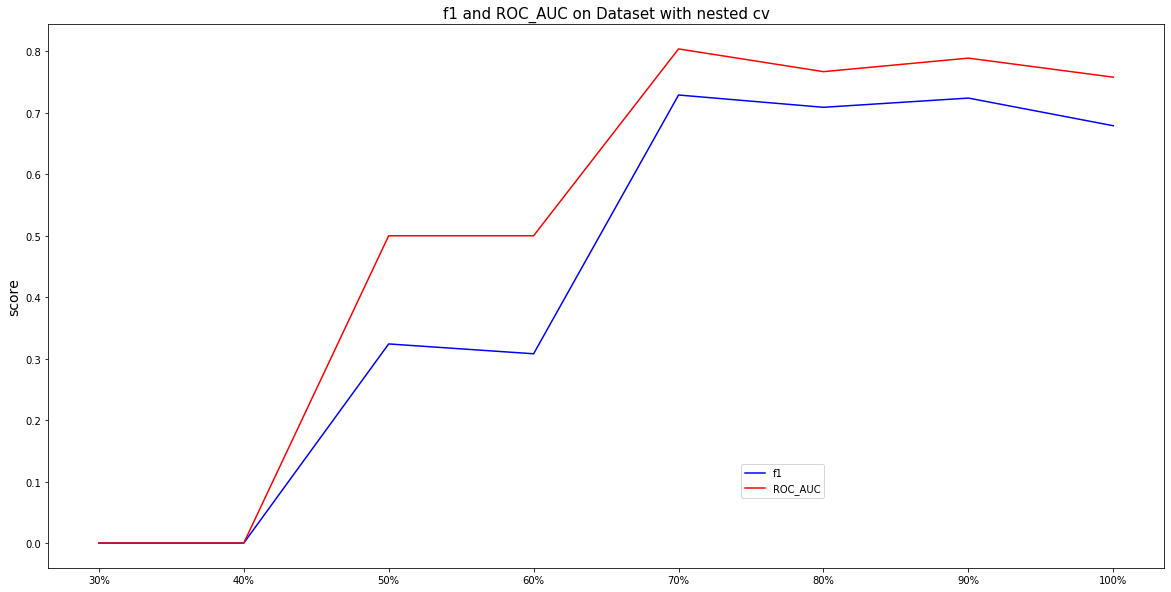

In [ ]:
###########################################################################
#                               Pull Data                                 #
###########################################################################
Type = 'Kmeans1'

###########################################################################
#                            SKdown Sampled                               #
###########################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML DS
path2file = 'H:\\Pickles\\ML_Stratified\\V2\\'+ Type + '\\'
# R DS
# path2file = 'H:\\Pickles\\RandomSampled\\'+ Type + '\\'

names = ['X_test.csv','y_test.csv']
file_obj = open(path2file + names[0], encoding="utf-8")
X = pd.read_csv(file_obj, low_memory=False, index_col=0)
file_obj = open(path2file + names[1], encoding="utf-8")
y = pd.read_csv(file_obj, low_memory=False, index_col=0, header=None)
y = y[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
XGBmodel = fast_boost(X_train, y_train, X_test, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
XGBmodel = fast_boost(X_train, y_train, X_test, y_test)

In [ ]:
###########################################################################
#                               Pull Data                                 #
###########################################################################
Type = 'Kmeans2'

###########################################################################
#                            SKdown Sampled                               #
###########################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML DS
path2file = 'H:\\Pickles\\ML_Stratified\\V2\\'+ Type + '\\'
# R DS
# path2file = 'H:\\Pickles\\RandomSampled\\'+ Type + '\\'

names = ['X_test.csv','y_test.csv']
file_obj = open(path2file + names[0], encoding="utf-8")
X = pd.read_csv(file_obj, low_memory=False, index_col=0)
file_obj = open(path2file + names[1], encoding="utf-8")
y = pd.read_csv(file_obj, low_memory=False, index_col=0, header=None)
y = y[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
XGBmodel = fast_boost(X_train, y_train, X_test, y_test)

In [ ]:
Type = 'SMOTEL'
###########################################################################
#                            SKdown Sampled                               #
###########################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML DS
path2file = 'H:\\Pickles\\ML_Stratified\\Small\\'+ Type + '\\'
# R DS
# path2file = 'H:\\Pickles\\RandomSampled\\'+ Type + '\\'

names = ['X_test.csv','y_test.csv', 'Full.csv']
file_obj = open(path2file + names[0], encoding="utf-8")
X = pd.read_csv(file_obj, low_memory=False, index_col=0)
file_obj = open(path2file + names[1], encoding="utf-8")
y = pd.read_csv(file_obj, low_memory=False, index_col=0)

file_obj = open(path2file + names[2], encoding="utf-8")
Full = pd.read_csv(file_obj, low_memory=False, index_col=0)

In [ ]:
TestPool = df[~df.index.isin(Full.index.to_list())]

In [ ]:
TestPoolCrash = TestPool[TestPool['Crash'] == 1]
TestPoolNONCrash = TestPool[TestPool['Crash'] == 0]

In [ ]:
TestPoolCrash.shape
TestNONCrash = TestPoolNONCrash.sample(n=TestPoolCrash.shape[0])
testsetter = pd.concat([TestNONCrash, TestPoolCrash])
X_testN = testsetter.drop(['Crash'],1)
y_testN = testsetter[['Crash']]

X_trainN = X
y_trainN = y['Crash']

In [ ]:
XGBmodel = fast_boost(X_trainN, y_trainN, X_testN, y_testN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def Knear(X_train, y_train, X_test, y_test):
    # Create a KNN Classifier
    knn = KNeighborsClassifier()

    # Hyperparameter Optimization
    parameters = {'n_neighbors': [3, 4, 5, 10], 
                  'weights': ['uniform', 'distance'],
                  'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size' : [10, 20, 30, 50]
                 }

    # Run the grid search
    grid_obj = GridSearchCV(knn, parameters)
    grid_obj = grid_obj.fit(X_train, y_train)

    # Set the knn to the best combination of parameters
    knn = grid_obj.best_estimator_

    # Train the model using the training sets 
    knn.fit(X_train,y_train)
    
    # Prediction on test data
    y_pred = knn.predict(X_test)
    
    # Confusion matrix and test 
    draw_cm(y_test, y_pred)
    Modeltest(X_test, y_test, y_pred, knn, 'K - Nearest Neighbors', SVM = False)

    return knn

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def evaluate(model, params, X, y):
    n_splits = 5
    n_repeats = 5
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    X_train_outter, X_test_outter, y_train_outter, y_test_outter = train_test_split(X, y['Crash'], test_size=0.2)


    clf = GridSearchCV(model, params, cv=cv, scoring='accuracy')
    clf.fit(X_train_outter, y_train_outter)

    scoring = {
        'accuracy':  metrics.make_scorer(metrics.accuracy_score),
        'f1':        metrics.make_scorer(metrics.f1_score),
        'precision': metrics.make_scorer(metrics.precision_score),
        'recall':    metrics.make_scorer(metrics.recall_score)}
    
    validation = cross_validate(clf.best_estimator_, X_test_outter, y_test_outter, scoring=scoring, cv=cv)
    scores = { score: [np.mean(validation['test_{}'.format(score)])] for score in scoring.keys() }

    return (clf.best_estimator_, scores)

################################################################################

#--- 0uter loop data ---#

from sklearn.tree import DecisionTreeClassifier
model = KNeighborsClassifier()

params = {'n_neighbors': [4, 5, 10, 12, 15, 20, 25, 30, 40 ,50], 
                  'weights': ['uniform', 'distance'],
                  'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size' : [10, 20, 30, 50]}

repeat = 10
# _, ax = plt.subplots(nrows=repeat, ncols=2)
# axes = list(it.chain(*ax))
non_nested_scores = np.zeros(repeat)
for i in range(0,repeat):
    
    model, scores = evaluate(model, params, X, y)
#     print(params)
    print(model)
    print(scores)
#     importance = pd.DataFrame(index=[X.columns],data={'Importance': model.feature_importances_})
#     importance = importance[importance['Importance'] > 0].sort_values(by=['Importance'], ascending=False)
#     print(importance)
    
Scores = pd.DataFrame()